### Info

Created by: Siep Bakker

Project: Thesis 2D flood modelling Geul catchment

In [1]:
import rasterio
from rasterio.features import shapes
from rasterio.crs import CRS

import numpy as np
from skimage import measure
from shapely.geometry import Polygon, MultiPolygon, MultiLineString, mapping, shape

import shapely.affinity
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import geopandas as gpd
import pandas as pd
import seaborn as sns

import datetime
import time

import os
import re
import glob

In [6]:
# Pathnames
# Working directories
WD_INPUT_8M = 'C:/Users/siepb/Documents/Studie_Hydrology/ThesisGeul/Inputmaps_8m/'
WD_OUTPUT_8M = 'D:/Documenten/Studie_Hydrology/Thesis/Output_Model/8m/'

# Input files
SimDomain_path_8m = 'SimDomain_8m.asc'
Catchment_outline_path = 'C:/Users/siepb/Documents/Studie_Hydrology/ThesisGeul/Catchment_outline_8m_DEM/Catchment_Outline_8m.shp'
Flood_ext_meas_path = 'D:/Documenten/Studie_Hydrology/Thesis/QGIS/GISdata_Floodzones/Geul_FloodExtent_v1.shp'
Flood_ext_meas_adj_path = f'{WD_OUTPUT_8M}Area_Of_Interest_Poly/Meas_flood_ext.shp'

# # Paths to different folder containing maximum modelled water depths
# Model_output_firts_path =  f'{WD_OUTPUT_8M}Model_Output/First_Cal_Round/'
# Model_output_sec_path =  f'{WD_OUTPUT_8M}Model_Output/Sec_Cal_Round/'
# Model_output_third_path = f'{WD_OUTPUT_8M}Model_Output/Third_cal_Round_Hourly/'
# Model_output_fourth_path = f'{WD_OUTPUT_8M}Model_Output/Fourth_Cal_Round/'
Model_output_fourth_path = f'{WD_OUTPUT_8M}Model_Output/Fourth_Cal_Round/'
Model_output_fourth_path_add = f'{WD_OUTPUT_8M}Model_Output/Fourth_Cal_Round_Additional/'
# Model_output_fifth_path = f'{WD_OUTPUT_8M}Model_Output/Fifth_Cal_Round/'

# Model_output_ECMWF_first_path = f'{WD_OUTPUT_8M}Model_Output/ECMWF_first_round/'
# Model_output_ECMWF_second_path = f'{WD_OUTPUT_8M}Model_Output/ECMWF_second_round/'

Model_output_KNMI_inf_and_burn_path = f'{WD_OUTPUT_8M}Model_Output/KNMI_inf_and_burn/'
Model_output_ECMWF_inf_and_burn_path = f'{WD_OUTPUT_8M}Model_Output/ECMWF_inf_and_burn/'

AreaOfInterest_path = f'{WD_OUTPUT_8M}Area_Of_Interest_Poly/flood_outline_draw_v2.shp'

Geul_stream_path = f'{WD_INPUT_8M}DEM_Adjust_And_Burn/Shapefiles/Stream_Geul_Complete_Dissolved.shp'
Netherlands_border_path = 'C:/Users/siepb/Documents/Studie_Hydrology/ThesisGeul/Raw_CountryBorders/Netherlands_OSM_Border.shp'

# Output files
Poly_flood_folder = f'{WD_OUTPUT_8M}Flood_Poly/'


NO_DATA = -9999
with rasterio.open(f'{WD_INPUT_8M}{SimDomain_path_8m}') as proj_outline:
    PROJECT_CRS = proj_outline.crs
    PROJECT_TRANSFORM = proj_outline.transform
    PROJECT_WIDTH = proj_outline.width
    PROJECT_HEIGHT = proj_outline.height
    PROJECT_SHAPE = proj_outline.shape
    PROJECT_BOUNDS = proj_outline.bounds
proj_outline.close()

## Adjusting the observed flood extent file AND the Area of interest map
#### Only needed to run the first time used
This shapefile depicts the flood extent that was deleniated using a DEM, model results and aerial imagery taken recorded subsequent to the 2021 floods.

In [3]:
# gdf = gpd.read_file(Flood_ext_meas_path)
# catchment = gpd.read_file(Catchment_outline_path)
# a_of_i = gpd.read_file(AreaOfInterest_path)

# # Reprojecting to project crs
# gdf = gdf.to_crs(PROJECT_CRS)

# # Dropping column that is not needed
# gdf = gdf.drop(['DN'], axis=1)

# # Clipping the measured flood extent to the catchment extent used in the model. This excludes a flooded area near Bunde. 
# gdf = gpd.clip(gdf, a_of_i, keep_geom_type = True)
    
# gdf.to_file(Flood_ext_meas_adj_path)

## Creating polygons from raster file
#### Slow but accurate

In [3]:
def CreatingPoly (Job_Num, File):
    print(Job_Num)
    Poly_flood_path = f'{Poly_flood_folder}{Job_Num}_poly_FloodedArea.shp'
    
    a_of_i = gpd.read_file(AreaOfInterest_path)
    gdf_geul = gpd.read_file(Geul_stream_path)
    # Creating a mask laye of the area where the flood level is above the flood threshhold (minimum level to be regarded as flooded area)
    with rasterio.open(File) as src:
        src_arr = src.read(1)   

        mask = np.zeros_like(src_arr)
        mask[src_arr > flood_thresh] = 1
        mask = mask.astype(rasterio.uint8)

        all_shapes = rasterio.features.shapes(src_arr, 
                                              mask = mask, 
                                              connectivity = 4, 
                                              transform = PROJECT_TRANSFORM)
        polygon = ([shapely.geometry.shape(polygon) for polygon, val in all_shapes])

    # Create a multipolygon from all normal polygons, otherwise the clipping will not work later
    merged_polygons = MultiPolygon(polygon)

    multipolygons = []
    polygons = []

    for poly in merged_polygons:
        if isinstance(poly, Polygon):
            polygons.append(poly)
        elif isinstance(poly, MultiPolygon):
            multipolygons.append(poly)
        else:
            raise ValueError("Invalid geometry type: {}".format(type(poly)))

    if len(polygons) > 0:
        multipolygons.append(MultiPolygon(polygons))

    # Creating a GeoDataFrame from the selected polygons
    gdf = gpd.GeoDataFrame(geometry=multipolygons)

    # Setting crs for the new GeoDataFrame and the catchment (the catchment has a similair crs but in a different format, so need to 'reproject')
    gdf.crs = PROJECT_CRS
    gdf = gdf.to_crs(PROJECT_CRS)

    gdf = gpd.clip(gdf, a_of_i, keep_geom_type=True)

    gdf.to_file(Poly_flood_path)

    # After saving the file there are some unnecessary columns, and a new column with the area is rquired. This is done in the part below, 
    # after which the file is saved to the same shapefile

    gdf = gpd.read_file(Poly_flood_path)

    gdf_geul = gdf_geul.to_crs(PROJECT_CRS)
    gdf = gpd.sjoin(gdf, gdf_geul, op='intersects')

    gdf = gdf.drop(['level_0', 'level_1'], axis=1).reset_index(drop=True)

    gdf.to_file(Poly_flood_path)

    Mod_ext = gpd.read_file(Poly_flood_path)
    Meas_ext = gpd.read_file(Flood_ext_meas_adj_path)

    TruePos = gpd.overlay(Meas_ext, Mod_ext,  how = 'intersection', keep_geom_type = True).reset_index(drop=True)
    FalseNeg = gpd.overlay(Meas_ext, TruePos, how = 'symmetric_difference')

    intermediate = gpd.overlay(Meas_ext, Mod_ext, how = 'symmetric_difference', keep_geom_type = True)
    FalsePos = gpd.overlay(intermediate, FalseNeg, how = 'symmetric_difference', keep_geom_type = True)

# # If not working, check if all the geom types are polygons and multipolygons
#     print(FalsePos.geom_type.unique())
#     print(Meas_ext.geom_type.unique())
#     print(Mod_ext.geom_type.unique())

    def adding_area(gdf):
        for i in range(len(gdf)): 
            gdf.loc[i, 'area_m2'] = shape(gdf.loc[i,'geometry']).area

    adding_area(TruePos)
    adding_area(FalsePos)
    adding_area(FalseNeg)

    TruePos.to_file(f'{WD_OUTPUT_8M}Temporary/{Job_Num}_TruePos.shp')
    FalseNeg.to_file(f'{WD_OUTPUT_8M}Temporary/{Job_Num}_FalseNeg.shp')
    FalsePos.to_file(f'{WD_OUTPUT_8M}Temporary/{Job_Num}_FalsePos.shp')

### True positive, false positive, false negative calculation

In [4]:
def CalcScores(Job_Num):
    TruePos = gpd.read_file(f'{WD_OUTPUT_8M}Temporary/{Job_Num}_TruePos.shp')
    FalseNeg = gpd.read_file(f'{WD_OUTPUT_8M}Temporary/{Job_Num}_FalseNeg.shp')
    FalsePos = gpd.read_file(f'{WD_OUTPUT_8M}Temporary/{Job_Num}_FalsePos.shp')

    AreaTP = TruePos['area_m2'].sum()
    AreaFN = FalseNeg['area_m2'].sum()
    AreaFP = FalsePos['area_m2'].sum()

    # Critical Succes Index (CSI). This is also called f<2>.
    CSI = (AreaTP)/(AreaTP + AreaFP + AreaFN) 
    print(f'{Job_Num} has a Critical Success Index of {CSI}')

    # The f3 score. Similar to the f2 score but a higher emphasis on False negatives.
    F_3 = (AreaTP-AreaFN)/(AreaTP + AreaFP + AreaFN)
    print(f'{Job_Num} has an f<3> score of {F_3}')
    
    # The Bias
    Bias = ((AreaTP+AreaFP) / (AreaTP+AreaFN))-1
    print(f'{Job_Num} has a Bias of {Bias}')
          
    Hit_Rate = AreaTP / (AreaTP+AreaFN)
    print(f'{Job_Num} has a Hit_Rate of {Hit_Rate}')
    
    return AreaTP, AreaFN, AreaFP, CSI, F_3, Bias, Hit_Rate

#### Running multiple jobs in a for loop

In [36]:
# >>>>> TO ADJUST <<<<<< 
# >>>>> First calibration round <<<<<
# Job_Num = 'Job_44'
# Jobs = list(range(31, 73))

# >>>>> SECOND ALIBRATION ROUND <<<<<<
# asc_files = glob.glob(Model_output_sec_path + '*.asc')
# selected_files = [file for file in asc_files if "the_0.94" in file or 'the_0.95' in file]
# pattern = r'Geul_8mRes_inf_(\d+\_the_\d+\.\d+_wd)'
# pattern2 = r'Geul_8mRes_inf_(\d+\.\d+\_the_\d+\.\d+_wd)'

# Job_Num = []
# for File in selected_files:
#     Job_Num.append((re.search(pattern + '|' +  pattern2, File)).group(0).replace('.', ''))

# >>>>> FOURTH CALIBRATION ROUND <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
# asc_files = glob.glob(Model_output_fourth_path + '*.asc')
# pattern = r'Geul_8m_inf_((\d+(?:\.\d+)?)_the_\d+\.\d+_alp_\d+\.\d+_wd)'

# # print(asc_files)

# Job_Num = []
# Burn = []
# Inf = []
# for File in asc_files:
#     search_result = (re.search(pattern, File))
# #     print(search_result)
#     Job_Num.append(search_result.group(0).replace('.', '')) 
#     Burn.append('Ge1Gu075')
#     Inf.append(search_result.group(2))


# >>>>> FIFTH CALIBRATION ROUND <<<<<<
# asc_files = glob.glob(Model_output_fifth_path + '*.asc')
# pattern = r'Geul_8m_Ge2Gu125_inf_(\d+\_the_\d+\.\d+_alp_\d+\.\d+_wd)'
# print(asc_files)

# Job_Num = []
# for File in asc_files:
#     Job_Num.append((re.search(pattern, File)).group(0).replace('.', ''))
# #     print(search_result)
# #     Job_Num.append(search_result.) 
# print(Job_Num)

# >>>>> ECMWF RUNS <<<<<

# >>>>> ECMWF first round <<<<<
# asc_files = glob.glob(Model_output_ECMWF_first_path + '*.asc')
# pattern = r'Geul_8mRes_ECMWF_(\d+_\d+_wd)'
# print(asc_files)
# Job_Num = []
# for File in asc_files:
#     print(File)
#     Job_Num.append(re.search(pattern, File).group(0))
#     print(Job_Num)

# >>>>> ECMWF second round <<<<<
# asc_files = glob.glob(Model_output_ECMWF_second_path + '*.asc')
# pattern = r'Geul_8mRes_ECMWF_(\d+_\d+_inf_\d+_the_\d+\.\d+_wd)'
# print(asc_files)
# Job_Num = []
# test = []
# for File in asc_files:
# #     print(File)
#     Job_Num.append(re.search(pattern, File).group(0))
# print(Job_Num)

# >>>>> KNMI inf and burn combination <<<<< 
# asc_files = glob.glob(Model_output_KNMI_inf_and_burn_path + '*.asc')
# # asc_files = glob.glob(Model_output_KNMI_inf_and_burn_path + '*inf_8*' + '*.asc')
# pattern = r'(Ge(\d+Gu\d+)_inf_(\d+(?:\.\d+)?)_)'
# # pattern = r'Geul_8m_KNMI_(Ge(\d+Gu\d+)_inf_(\d+(?:\.\d+)?)_)'

# Job_Num = [re.search(pattern, pathname).group(0) for pathname in asc_files]
# Burn = [re.search(pattern, pathname).group(2) for pathname in asc_files]
# Inf = [re.search(pattern, pathname).group(3) for pathname in asc_files]

# print(asc_files)


# >>>> ECMWF inf and burn combination <<<<< 
asc_files = glob.glob(Model_output_ECMWF_inf_and_burn_path + '*.asc')
pattern = r'Geul_8m_ECMWF_13_00_(Ge(\d+Gu\d+)_inf_(\d+(?:\.\d+)?)_)'

Job_Num = [re.search(pattern, pathname).group(0) for pathname in asc_files]
Burn = [re.search(pattern, pathname).group(2) for pathname in asc_files]
Inf = [re.search(pattern, pathname).group(3) for pathname in asc_files]

print(asc_files)

In [22]:
flood_thresh = 0.05 #Level above which the waterlevel is deemed part of the flood

# # For cal round (2)
# for File, Job in zip(selected_files, Job_Num):
#     CreatingPoly(Job_Num, File)

# # For cal round (4)
# for File, Job in zip(asc_files, Job_Num):
#     CreatingPoly(Job, File)
#     print(Job)

for File, Job in zip(asc_files, Job_Num): 
    CreatingPoly(Job, File)

In [38]:
results = []

for i, Job in enumerate(Job_Num):
    AreaTP, AreaFN, AreaFP, CSI, F_3, Bias, Hit_Rate = CalcScores(Job)
    results.append((Job, Burn[i], Inf[i], AreaTP, AreaFN, AreaFP, CSI, F_3, Bias, Hit_Rate)) 
    
df = pd.DataFrame(results, columns = ['Job', 'Burn', 'Inf', 'AreaTP', 'AreaFN', 'AreaFP', 'CSI', 'F_3', 'Bias', 'Hit_Rate'])
df.to_csv(f'{WD_OUTPUT_8M}Results_CSV/Results.csv', index=False)

Geul_8m_inf_15_the_070_alp_050_wd has a Critical Success Index of 0.671848312059244
Geul_8m_inf_15_the_070_alp_050_wd has an f<3> score of 0.6556993504428809
Geul_8m_inf_15_the_070_alp_050_wd has a Bias of 0.43002171088184493
Geul_8m_inf_15_the_070_alp_050_wd has a Hit_Rate of 0.9765275790555277
Geul_8m_inf_15_the_070_alp_060_wd has a Critical Success Index of 0.6706589612929146
Geul_8m_inf_15_the_070_alp_060_wd has an f<3> score of 0.6552562792127307
Geul_8m_inf_15_the_070_alp_060_wd has a Bias of 0.4351440973713874
Geul_8m_inf_15_the_070_alp_060_wd has a Hit_Rate of 0.9775491280864284
Geul_8m_inf_15_the_070_alp_070_wd has a Critical Success Index of 0.6710444509200815
Geul_8m_inf_15_the_070_alp_070_wd has an f<3> score of 0.6556507940697108
Geul_8m_inf_15_the_070_alp_070_wd has a Bias of 0.4343701668131834
Geul_8m_inf_15_the_070_alp_070_wd has a Hit_Rate of 0.9775745887704732
Geul_8m_inf_15_the_070_alp_080_wd has a Critical Success Index of 0.670905913552659
Geul_8m_inf_15_the_070_al

## Visualization Old good version

250Gu225
1Gu075


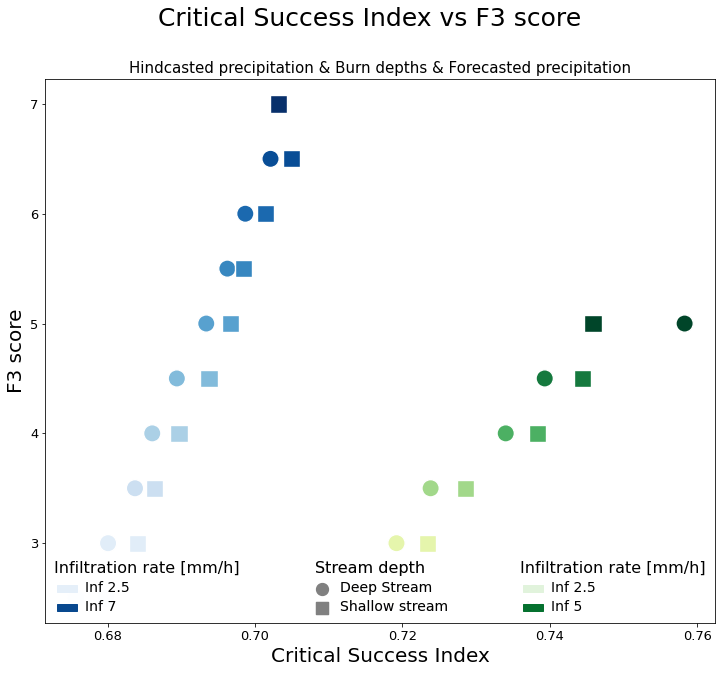

In [21]:
# # csv_file_ECMWF = 'Results_ECMWF_Inf_and_burn'
# csv_file_KNMI = 'Results_KNMI_Inf_and_burn'
# csv_file_ECMWF = 'Results_ECMWF_Inf_and_Burn'
# # data_ECMWF = pd.read_csv(f'{WD_OUTPUT_8M}{csv_file_ECMWF}.csv')
# data_KNMI = pd.read_csv(f'{WD_OUTPUT_8M}Results_CSV/{csv_file_KNMI}.csv')

# data_ECMWF = pd.read_csv(f'{WD_OUTPUT_8M}Results_CSV/{csv_file_ECMWF}.csv')

# # job_name_ECMWF = data_ECMWF['Job'].tolist()
# # job_name_cal = data_cal['Job'].tolist()
# # print(job_name_cal)

# # print(jo)

# # inf_rate_ECMWF = [int(re.search(r'inf_(\d+)', filestring).group(1)) for filestring in job_name_ECMWF]
# # inf_rate_cal = [float(re.search(r'inf_(\d+)', filestring).group(1)) for filestring in job_name_cal]

# # # if needed devide some of th in fumbers by 10
# # inf_rate_cal = [num / 10 if num > 10 else num for num in inf_rate_cal]

# # theta_cal = [float(re.search(r'the_(\d+)', filestring).group(1)) for filestring in job_name_cal]
# # alpha_cal = [float(re.search(r'alp_(\d+)', filestring).group(1)) for filestring in job_name_cal]

# # theta_cal = [num/100 for num in theta_cal]
# # alpha_cal = [num/100 for num in alpha_cal]
# # print(inf_rate_cal)

# # data_ECMWF['inf'] = inf_rate_ECMWF
# # data_cal['inf']   = inf_rate_cal
# # data_cal['theta'] = theta_cal
# # data_cal['alpha'] = alpha_cal
# # print(data_cal.head())

# # color_palette = ['Blues', 'Greens', 'Reds', 'Purples', 'Oranges', 'pink', 'gray', 'cool', 'ocean', 'dark']
# markers = ['o', 'D', '^', 'P', 'X', 'h', '*','v', '+', 's']
# Burn_depths = ['250Gu225','250Gu175', '250Gu125', '250Gu075', '2Gu175', '2Gu125', '2Gu075', '150Gu125', '150Gu075', '1Gu075']

# ax, fig = plt.subplots(figsize=(12, 10)) 


# for burn, mark in zip([Burn_depths[0], Burn_depths[9]] , [markers[0], markers[9]]):
# # for burn, mark in zip([Burn_depths[0]] , [markers[0]]):
#     print(burn)
#     data_KNMI_select = data_KNMI[data_KNMI['Burn'] == burn]
#     sns.scatterplot(x = data_KNMI_select['CSI'], 
#                     y = data_KNMI_select['F_3'], 
#                     hue = data_KNMI_select['Inf'],
#                     palette = 'Blues',
#                     marker = mark,
#                     label = burn,
#                     legend = False,
#                     s = 300,)


# # ECMWF infiltration plots <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
    
# inf_rates = [2.5, 3, 3.5, 4, 4.5, 5]
# data_ECMWF_sel = pd.DataFrame()

# for inf in inf_rates: 
#     selected_data = data_ECMWF[data_ECMWF['Inf'] == inf]
#     data_ECMWF_sel = data_ECMWF_sel.append(selected_data)
# for burn, mark in zip([Burn_depths[0], Burn_depths[9]] , [markers[0], markers[9]]):
#     data_ECMWF_select = data_ECMWF_sel[data_ECMWF_sel['Burn'] == burn]
#     sns.scatterplot(x = data_ECMWF_select['CSI'], 
#                     y = data_ECMWF_select['F_3'], 
#                     hue = data_ECMWF_select['Inf'],
#                     palette = 'YlGn',
#                     marker = mark,
#                     label = burn,
#                     legend = False,
#                     s = 300,)

# ##### FOR THESIS <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

# # for burn, mark, col in zip(Burn_depths[1:9], markers[1:9], color_palette[1:9]):
# #     data_KNMI_select = data_KNMI[data_KNMI['Burn'] == burn]
# #     sns.scatterplot(x=data_KNMI_select['CSI'], 
# #                     y=data_KNMI_select['F_3'], 
# #                     hue=data_KNMI_select['Inf'],
# #                     palette= 'RdBu',
# #                     alpha= 0.1, 
# #                     marker= mark,
# #                     legend= False,
# #                     s=300)

# # for burn, mark, col in zip(Burn_depths[1:9], markers[1:9], color_palette[1:9]):
# #     data_ECMWF_select = data_ECMWF[data_ECMWF['Burn'] == burn]
# #     sns.scatterplot(x=data_ECMWF_select['CSI'], 
# #                     y=data_ECMWF_select['F_3'], 
# #                     hue=data_ECMWF_select['Inf'],
# #                     palette= 'RdBu',
# #                     alpha= 0.1, 
# #                     marker= mark,
# #                     legend= False,
# #                     s=300)

# # >>>> KNMI INFILTRATION LABELS <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
# inf_palette = sns.color_palette('Blues', n_colors=10)
# selected_colors = [inf_palette[0], inf_palette[9]]
# inf_labels = ['Inf 2.5                        ', 'Inf 7'] 
# inf_handles = [mpatches.Patch(color=color) for color in selected_colors]
# legend_Inf = plt.legend(handles=inf_handles, labels=inf_labels, title='Infiltration rate [mm/h]', loc='lower left')
# plt.gca().add_artist(legend_Inf)

# # Adjust the size of the legend
# legend_Inf.get_title().set_fontsize(16)  # Set the title font size
# legend_Inf.get_frame().set_linewidth(0.0)  # Remove the border

# # Adjust the labels font size
# for label in legend_Inf.get_texts():
#     label.set_fontsize(14)
    
# # >>>> ECMWF INFILTRATION LEGEND <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
# inf_palette = sns.color_palette('Greens', n_colors=6)
# selected_colors = [inf_palette[0], inf_palette[5]]
# inf_labels = ['Inf 2.5                        ', 'Inf 5'] 
# inf_handles = [mpatches.Patch(color=color) for color in selected_colors]
# legend_inf_ECMWF = plt.legend(handles=inf_handles, labels=inf_labels, title='Infiltration rate [mm/h]', loc='lower right')
# plt.gca().add_artist(legend_inf_ECMWF)

# # Adjust the size of the legend
# legend_inf_ECMWF.get_title().set_fontsize(16)  # Set the title font size
# legend_inf_ECMWF.get_frame().set_linewidth(0.0)  # Remove the border

# # Adjust the labels font size
# for label in legend_inf_ECMWF.get_texts():
#     label.set_fontsize(14)

    
# # >>>>> BURN DEPTH LABELS <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
# burn_labels = ['Deep Stream', 'Shallow stream']
# legend_burn = plt.legend(labels = burn_labels, title='Stream depth    ', loc='lower center')
# plt.gca().add_artist(legend_burn)

# # Adjust the size of the legend
# legend_burn.get_title().set_fontsize(16)  # Set the title font size
# legend_burn.get_frame().set_linewidth(0.0)  # Remove the border

# # Adjust the labels font size
# for label in legend_burn.get_texts():
#     label.set_fontsize(14)

# legend_burn.legendHandles[0].set_color('Grey')
# legend_burn.legendHandles[1].set_color('Grey')
# legend_burn.legendHandles[0]._sizes= [140]
# legend_burn.legendHandles[1]._sizes= [140]
    
# # >>>> AXES LABELS <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
# plt.xlabel('Critical Success Index', size = 20)
# plt.xticks(size = 13)

# plt.ylabel('F3 score', size = 20)
# plt.yticks(size =13)
# plt.suptitle('Critical Success Index vs F3 score', size=25)
# plt.title('Hindcasted precipitation & Burn depths & Forecasted precipitation', size=15)


# plt.savefig(r'D:\Documenten\Studie_Hydrology\Thesis\Styled_maps\JPEG_PNG\Presentation_CSI_vs_F3_Infiltration_Burn_ECMWFinf.jpg', dpi=700)
# plt.show()

(0.66, 0.74)

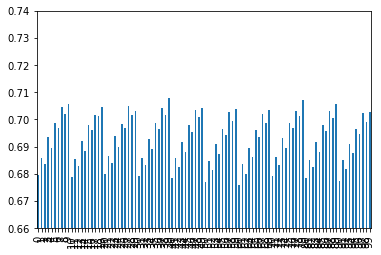

In [70]:
# x = data_KNMI['Burn']
# y = data_KNMI['CSI']
# colors = data_KNMI['Inf']

# norm = mcolors.Normalize(vmin=colors.min(), vmax=colors.max())
# # Map the normalized values to RGBA colors
# color_map = plt.cm.get_cmap('viridis')  # Choose a colormap, e.g., 'viridis'
# colors_rgba = color_map(norm(colors))
# print(colors_rgba)


# fig, ax = plt.subplots()

# bars = ax.bar(x, y , color=colors_rgba)
# ax.set_ylim(0.6, 0.74)

# plt.show()


ax = data_KNMI['CSI'].plot(col = kind = 'bar', stacked = False)
ax.set_ylim(0.66, 0.74)

#### Plotting shapefile in python

In [ ]:
# fig, ax = plt.subplots()
# for polygon in polygon:
#     ax.plot(*polygon.exterior.xy)
# plt.show()

## Creating polygons from raster file
#### Fast but less accurate

In [33]:
# Job_Num = 'Job_20'
# File = f'Geul_8mRes_{Job_Num}_wd_max'
# flood_thresh = 0.1

# with rasterio.open(f'{WD_OUTPUT_8M}{Job_Num}/{File}.asc') as src:
#     catchment = gpd.read_file('C:/Users/siepb/Documents/Studie_Hydrology/ThesisGeul/Catchment_outline_8m_DEM/Catchment_Outline_8m.shp')
    
    
#     src_arr = src.read(1)
#     mask = np.zeros_like(src_arr)
#     mask[src_arr > flood_thresh] = 1
#     mask = mask.astype(rasterio.uint8)

# #     all_shapes = rasterio.features.shapes(mask, 
# #                                           mask=mask, 
# #                                           connectivity = 8, 
# #                                           transform = PROJECT_TRANSFORM)
# #     polygon = ([shapely.geometry.shape(polygon) for polygon, val in all_shapes if val == 1])


#     all_shapes = rasterio.features.shapes(src_arr, 
#                                           mask=mask, 
#                                           connectivity = 4, 
#                                           transform = PROJECT_TRANSFORM)
#     polygon = ([shapely.geometry.shape(polygon) for polygon, val in all_shapes])

#     multi_polygon = MultiPolygon(polygon)
#     merged_polygons = multi_polygon.buffer(0)

# ###### From AI
#     multipolygons = []
#     polygons = []

#     for poly in merged_polygons:
#         if isinstance(poly, Polygon):
#             polygons.append(poly)
#         elif isinstance(poly, MultiPolygon):
#             multipolygons.append(poly)
#         else:
#             raise ValueError("Invalid geometry type: {}".format(type(poly)))

#     if len(polygons) > 0:
#         multipolygons.append(MultiPolygon(polygons))

#     gdf = gpd.GeoDataFrame(geometry=multipolygons)

# #############################

# #     gdf = gpd.GeoDataFrame(geometry = merged_polygons)
    
# #     gdf = gdf.geometry.buffer(0)

#     gdf.crs = PROJECT_CRS
#     gdf = gdf.to_crs(PROJECT_CRS)
#     catchment = catchment.to_crs(gdf.crs)

#     gdf = gpd.clip(gdf, catchment, keep_geom_type = True)
    
# # Saving to .gpkg instead of .shp is essential, because the .shp format cant handles polygon lines crossing over itself
# # More info on this problem in https://github.com/rasterio/rasterio/issues/1126 AND https://github.com/ai4er-cdt/geograph/issues/18
#     gdf.to_file(f'{WD_OUTPUT_8M}Temporary/{File}_poly_merged.gpkg', driver = 'GPKG')

6612


In [ ]:
# Old way for calculating false posiives
# intermediate = gpd.overlay(Meas_ext, Mod_ext, how = 'symmetric_difference')
# FalsePos = gpd.overlay(intermediate, FalseNeg, how = 'symmetric_difference', keep_geom_type = False)